# Correlation plots for ov-fiets and weather data

Imports

In [15]:
import pandas as pd
import pyarrow as pa
import matplotlib.pyplot as plt
import seaborn as sns
import json
import plotly.express as px
import numpy as np
import os
import plotly.graph_objects as go
from datetime import datetime
import glob
import pyarrow

## Setup of OV-fiets

In [16]:
## Use previously parsed data, now turned into parquet files

# Function to calculate the amount of bikes rented out per day per rental location (multiple for one train station)

def compute_daily_rentals_from_file(file_path):
    """Compute total number of bikes rented out per rental location per day from one parquet file."""
    df = pd.read_parquet(file_path)

    # Ensure correct time order
    df["time"] = pd.to_datetime(df["time"], errors="coerce")
    df = df.sort_values(["description", "time"])

    # Group by station
    results = []
    for station_description, group in df.groupby("description"):
        group = group.sort_values("time")
        group["delta"] = group["extra.rentalBikes"].diff() ##
        # print(group)

        # Only count decreases in bike availability
        group["rentals"] = group["delta"].where(group["delta"] < 0, 0).abs()

        total_rentals = group["rentals"].sum()
        date = group["time"].dt.date.iloc[0]
        station_code = group["stationCode"].unique()
        station_string = np.array2string(station_code)
        # print(type(station_code))

        results.append({
            "description": station_description,
            "date": date,
            "total_rentals": total_rentals,
            "stationCode": station_string
        })

    return pd.DataFrame(results)


In [17]:
## Function to sum the daily rentals for one station (multiple locations)

def compute_total_daily_rentals(df2):
    # Ensure correct time order
    df2["date"] = pd.to_datetime(df2["date"], errors="coerce")
    df2 = df2.sort_values(["stationCode", "date"])

    # Group by station
    results2 = []
    for station, group in df2.groupby("stationCode"):
        group = group.sort_values("date")

        total_rentals_station = group["total_rentals"].sum()

        date = group["date"].dt.date.iloc[0]

        results2.append({
            "station": station,
            "date": date,
            "total_rentals_station": total_rentals_station
        })

    return pd.DataFrame(results2)

In [18]:
# Load the parsed parquet data files and calculate the amount of bikes rented out daily per station
# Save those numbers to a new parquet file

daily_summaries = []
input_folder = "ovfiets_parquet"
output_folder = "ovfiets_daily"
# os.makedirs(output_folder, exist_ok=True)

for file in os.listdir(input_folder):
        path = os.path.join(input_folder, file)
        df_day_intermediate = compute_daily_rentals_from_file(path)
        df_day = compute_total_daily_rentals(df_day_intermediate)
        daily_summaries.append(df_day)


# Combine all daily results into one DataFrame
df_daily = pd.concat(daily_summaries, ignore_index=True)

# Save compact version
output_file = os.path.join(output_folder, 'daily_rentals.parquet')
df_daily.to_parquet(output_file, index=False)
print(f"✅ Saved daily totals to {output_file}")


✅ Saved daily totals to ovfiets_daily\daily_rentals.parquet


## Calculating weekly average OV-fiets rental number

In [19]:
# Open the parquet file containing the daily rental numbers

df_daily = pd.read_parquet("ovfiets_daily/daily_rentals.parquet")
df_daily["date"] = pd.to_datetime(df_daily["date"])

# Calculate the weekly average rental numbers

weekly_avg_ov_fiets = (
    df_daily
    .set_index("date")
    .groupby("station")
    ["total_rentals_station"]
    .resample("W")
    .mean()
    .reset_index()
)

print(weekly_avg_ov_fiets)


     station       date  total_rentals_station
0    ['ASD'] 2023-01-08            2474.285714
1    ['ASD'] 2023-01-15            3182.857143
2    ['ASD'] 2023-01-22            3537.571429
3    ['ASD'] 2023-01-29            3628.428571
4    ['ASD'] 2023-02-05            1316.428571
..       ...        ...                    ...
619   ['ZL'] 2023-12-03            1061.571429
620   ['ZL'] 2023-12-10             594.000000
621   ['ZL'] 2023-12-17             839.285714
622   ['ZL'] 2023-12-24             655.285714
623   ['ZL'] 2023-12-31             481.857143

[624 rows x 3 columns]


In [20]:
## normalize ov-fiets data using z-score normalization

weekly_avg_ov_fiets['norm_rentals'] = (
    weekly_avg_ov_fiets.groupby('station')['total_rentals_station']
    .transform(lambda x: (x - x.mean()) / x.std())
)

weekly_avg_ov_fiets['station'] = weekly_avg_ov_fiets['station'].str.strip("[]' ")

print(weekly_avg_ov_fiets)

    station       date  total_rentals_station  norm_rentals
0       ASD 2023-01-08            2474.285714      1.551706
1       ASD 2023-01-15            3182.857143      2.972542
2       ASD 2023-01-22            3537.571429      3.683819
3       ASD 2023-01-29            3628.428571      3.866007
4       ASD 2023-02-05            1316.428571     -0.770044
..      ...        ...                    ...           ...
619      ZL 2023-12-03            1061.571429      0.454619
620      ZL 2023-12-10             594.000000     -1.648050
621      ZL 2023-12-17             839.285714     -0.545000
622      ZL 2023-12-24             655.285714     -1.372448
623      ZL 2023-12-31             481.857143     -2.152357

[624 rows x 4 columns]


## Setup of KNMI data

In [21]:
## READ IN KNMI DATA

#Daily file
# TG: Etmaalgemiddelde temperatuur (in 0.1 graden Celsius)
# TX: Maximum temperatuur (in 0.1 graden Celsius)
# RH: Etmaalsom van de neerslag (in 0.1 mm) (-1 voor <0.05 mm)

knmi_file = 'knmi_data/knmi_daily_20230102_20231231.txt'

knmi_data = pd.read_csv(knmi_file,  sep=",",          # tab-separated values
    engine="python",   # more tolerant of inconsistent line lengths
    header=60,          # or None if there’s no header
    na_values=["", "NA", "NaN"],  # handle missing entries
    on_bad_lines="skip"  # skip malformed rows (or use 'warn')
)

print(knmi_data.head())

knmi_data.rename(columns={"# STN": "station_code"}, inplace=True)
knmi_data.columns = knmi_data.columns.str.strip()
knmi_data["date"] = pd.to_datetime(knmi_data["YYYYMMDD"], format="%Y%m%d")
knmi_data = knmi_data.set_index("date")

knmi_data = knmi_data.apply(pd.to_numeric, errors='coerce')


print(knmi_data.head())

   # STN  YYYYMMDD     TG     TX     RH
0    209  20230102                     
1    209  20230103                     
2    209  20230104                     
3    209  20230105                     
4    209  20230106                     
            station_code  YYYYMMDD  TG  TX  RH
date                                          
2023-01-02           209  20230102 NaN NaN NaN
2023-01-03           209  20230103 NaN NaN NaN
2023-01-04           209  20230104 NaN NaN NaN
2023-01-05           209  20230105 NaN NaN NaN
2023-01-06           209  20230106 NaN NaN NaN


## Calculating weekly average temperature 


In [22]:
# All weather stations:
 
# pick chosen weather stations:
weather_locations = {'ASD': np.int64(240), 'DT': np.int64(344), 'GVC': np.int64(215), 'EHV': np.int64(370), 
                     'UT': np.int64(260), 'MT': np.int64(380), 'RTD': np.int64(344), 'MDB': np.int64(310), 
                     'NM': np.int64(375), 'ZL': np.int64(278), 'ES': np.int64(290), 'GN': np.int64(280)}


weekly_avg_knmi = {}  # dictionary to store results

for ov_station, weather_code in weather_locations.items():
    # Filter for one weather station
    one_station = knmi_data[knmi_data["station_code"] == weather_code]

    # Compute weekly mean of TX (max temperature), and the weekly sum of daily rainfall
    weekly_avg = one_station.resample('W').agg({'TX': 'mean', 'RH': 'sum'})

    # Store in dictionary with readable key
    weekly_avg_knmi[ov_station] = weekly_avg

print(weekly_avg_knmi["DT"].head()) # access one station

# Create dataframe containing all stations, the dates, and their weather info
knmi_list = []

for station, df in weekly_avg_knmi.items():
    temp_df = pd.DataFrame({
        "station": station,
        "date": df.index,
        "temperature": df["TX"].values,
        "rainfall": df["RH"].values
    })
    knmi_list.append(temp_df)

knmi_df = pd.concat(knmi_list, ignore_index=True)


                    TX     RH
date                         
2023-01-08  112.714286  250.0
2023-01-15  106.000000  739.0
2023-01-22   41.714286  416.0
2023-01-29   53.571429   32.0
2023-02-05   92.857143   48.0


## Correlation plot delft station  2023

In [23]:
# merge weekly averages

merged = weekly_avg_ov_fiets.merge(knmi_df, on=['station', 'date'])

merged['temperature'] = merged['temperature'] / 10  # change temperature to degrees instead of 0.1 degrees celsius
merged['rainfall'] = merged['rainfall'] / 10        # change rainfall to mm instead of 0.1 mm

station_labels = {
    "ASD": "Amsterdam Centraal",
    "DT": "Delft",
    "GVC": "Den Haag Centraal",
    "EHV": "Eindhoven Centraal",
    "UT": "Utrecht Centraal",
    "MT": "Maastricht",
    "RTD": "Rotterdam Centraal",
    "MDB": "Middelburg",
    "NM": "Nijmegen",
    "ZL": "Zwolle",
    "ES": "Enschede",
    "GN": "Groningen"
}

# Replace station codes with full names
merged["station_full"] = merged["station"].map(station_labels)



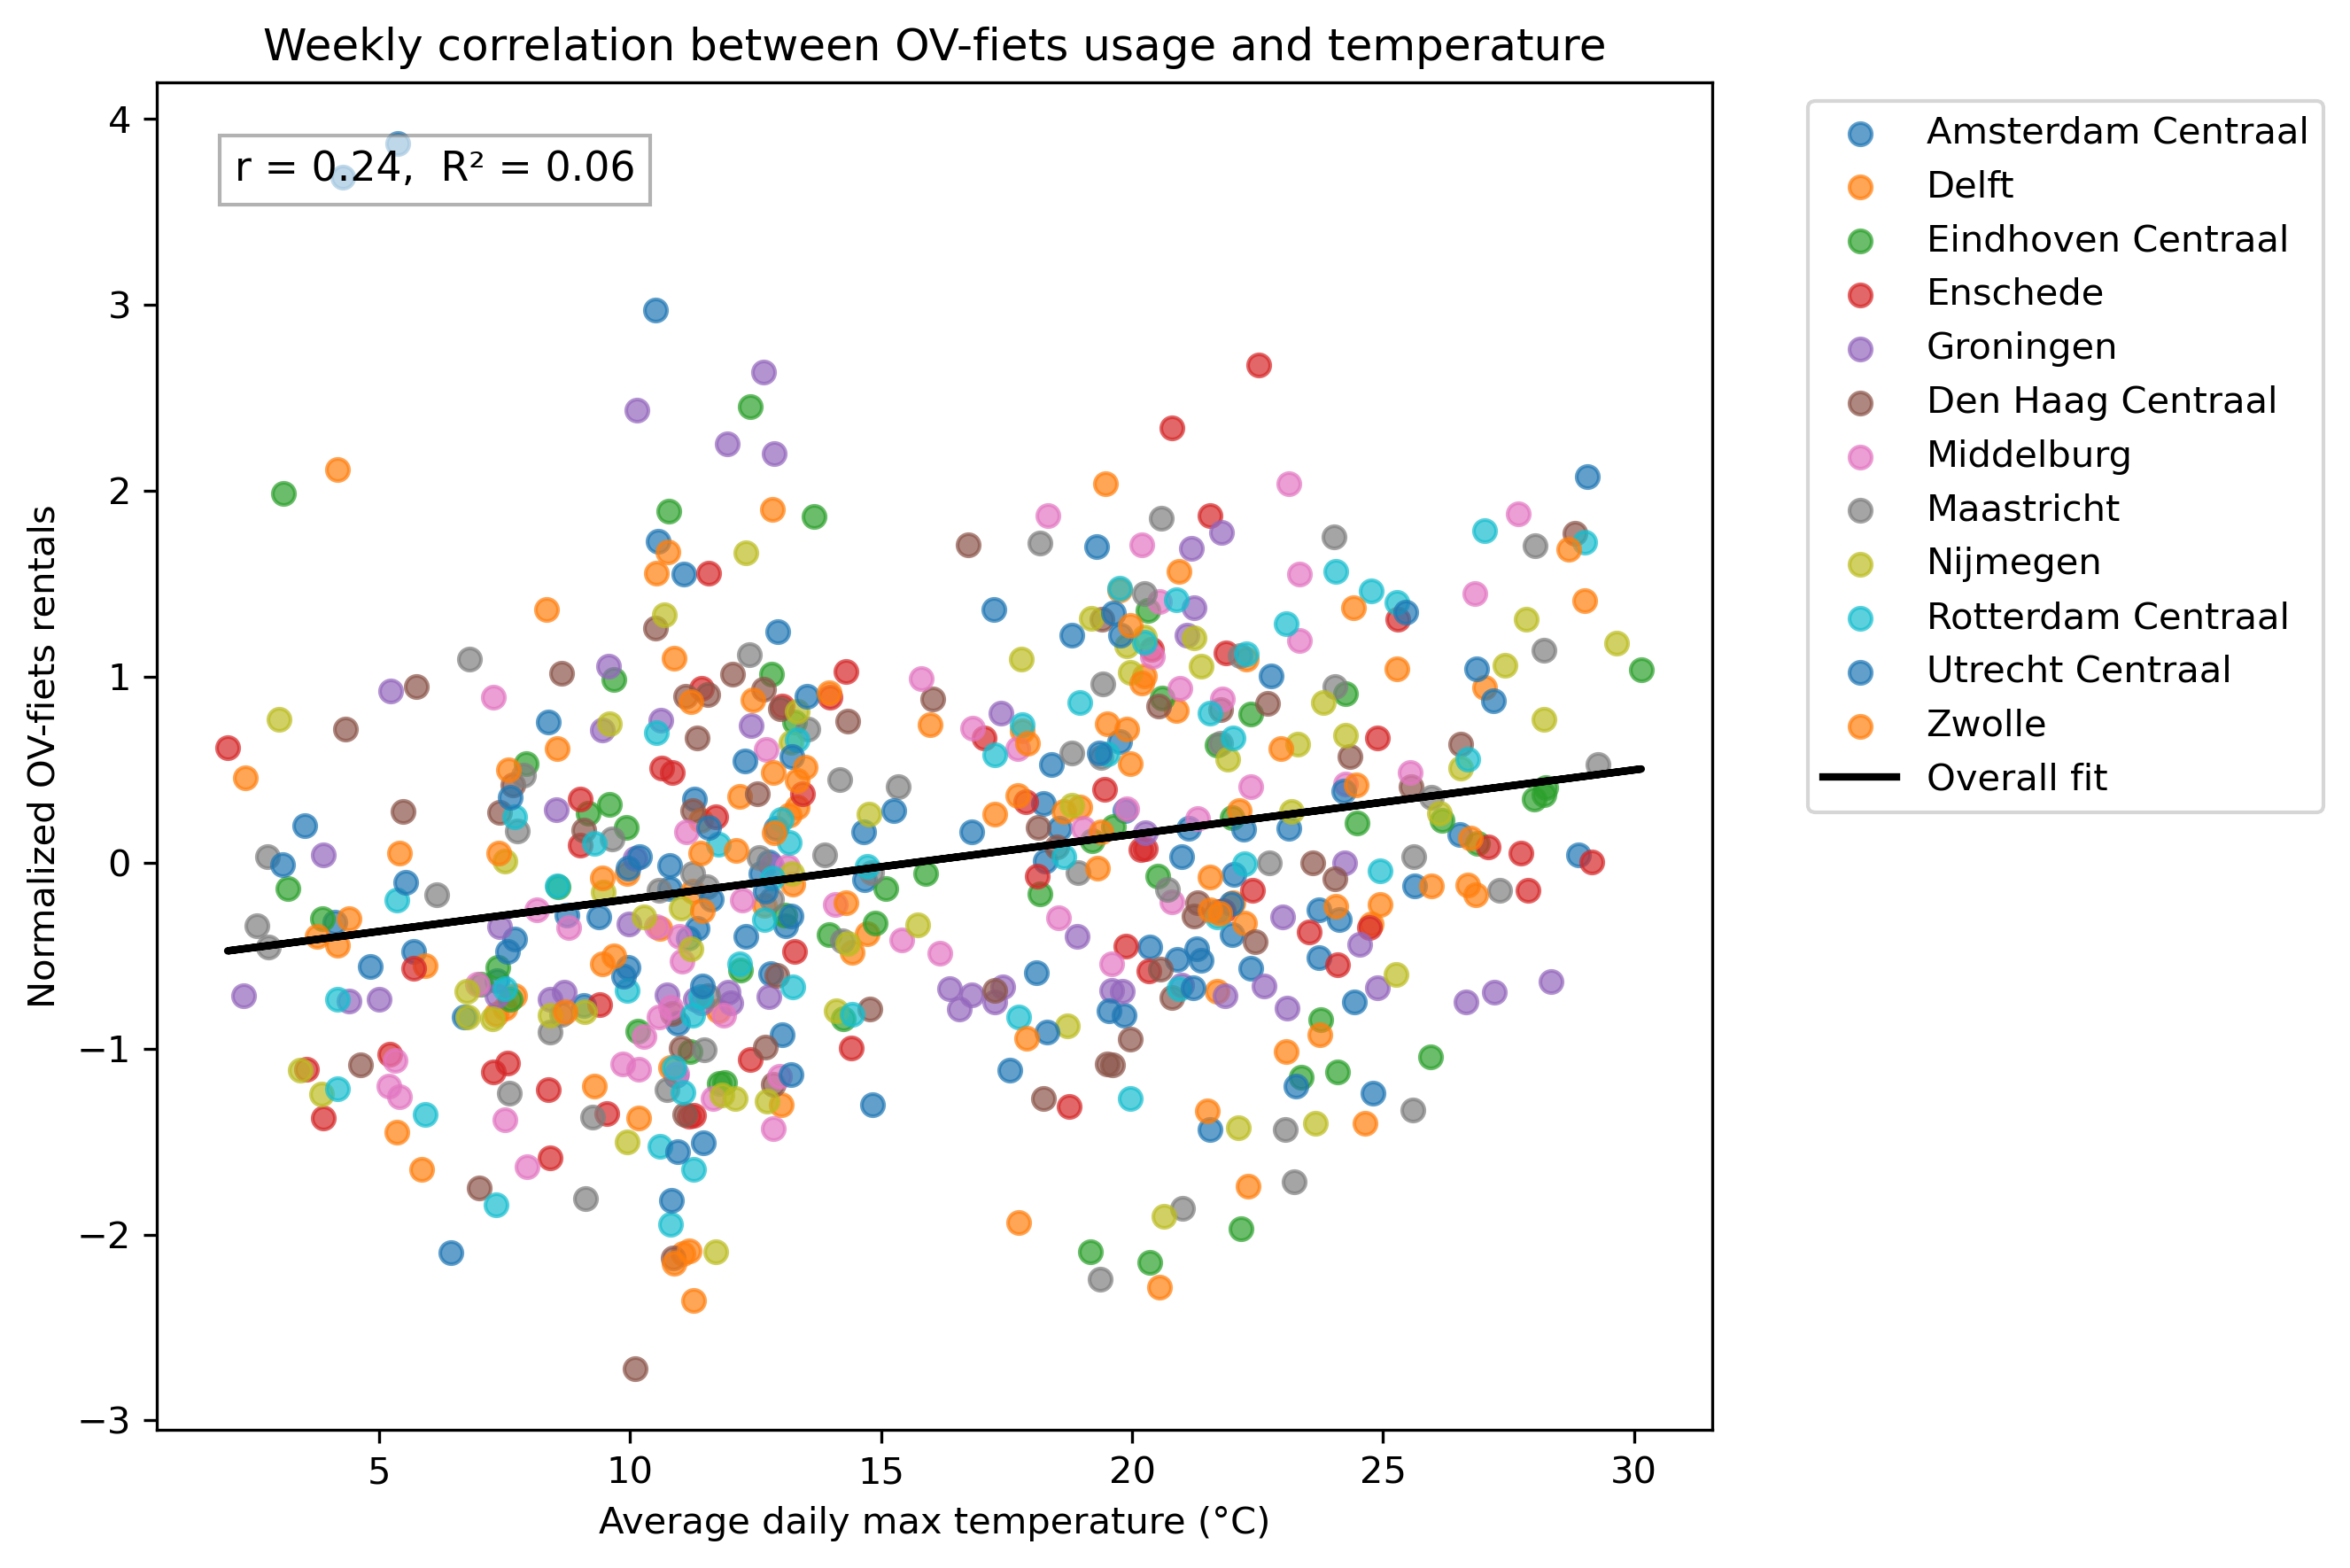

In [24]:
# Plot  temperature correlation for multiple stations with linear fit

plt.figure(figsize=(9,6),dpi=300)

# Scatter points per station
for st in merged["station_full"].unique():
    subset = merged[merged["station_full"] == st]
    plt.scatter(
        subset["temperature"],
        subset["norm_rentals"],
        label=st,
        alpha=0.7
    )

# Overall linear fit
x = merged["temperature"]
y = merged["norm_rentals"]
m, b = np.polyfit(x, y, 1)
plt.plot(x, m*x + b, color="black", linewidth=2, label="Overall fit")

# Compute overall correlation
r = np.corrcoef(x, y)[0, 1]
r_squared = r**2

# Add correlation text
plt.text(
    0.05, 0.95,
    f"r = {r:.2f},  R² = {r_squared:.2f}",
    transform=plt.gca().transAxes,
    fontsize=11,
    verticalalignment='top',
    bbox=dict(facecolor='white', alpha=0.6, edgecolor='gray')
)

# Labels and title
plt.xlabel("Average daily max temperature (°C)")
plt.ylabel("Normalized OV-fiets rentals")
plt.title("Weekly correlation between OV-fiets usage and temperature")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


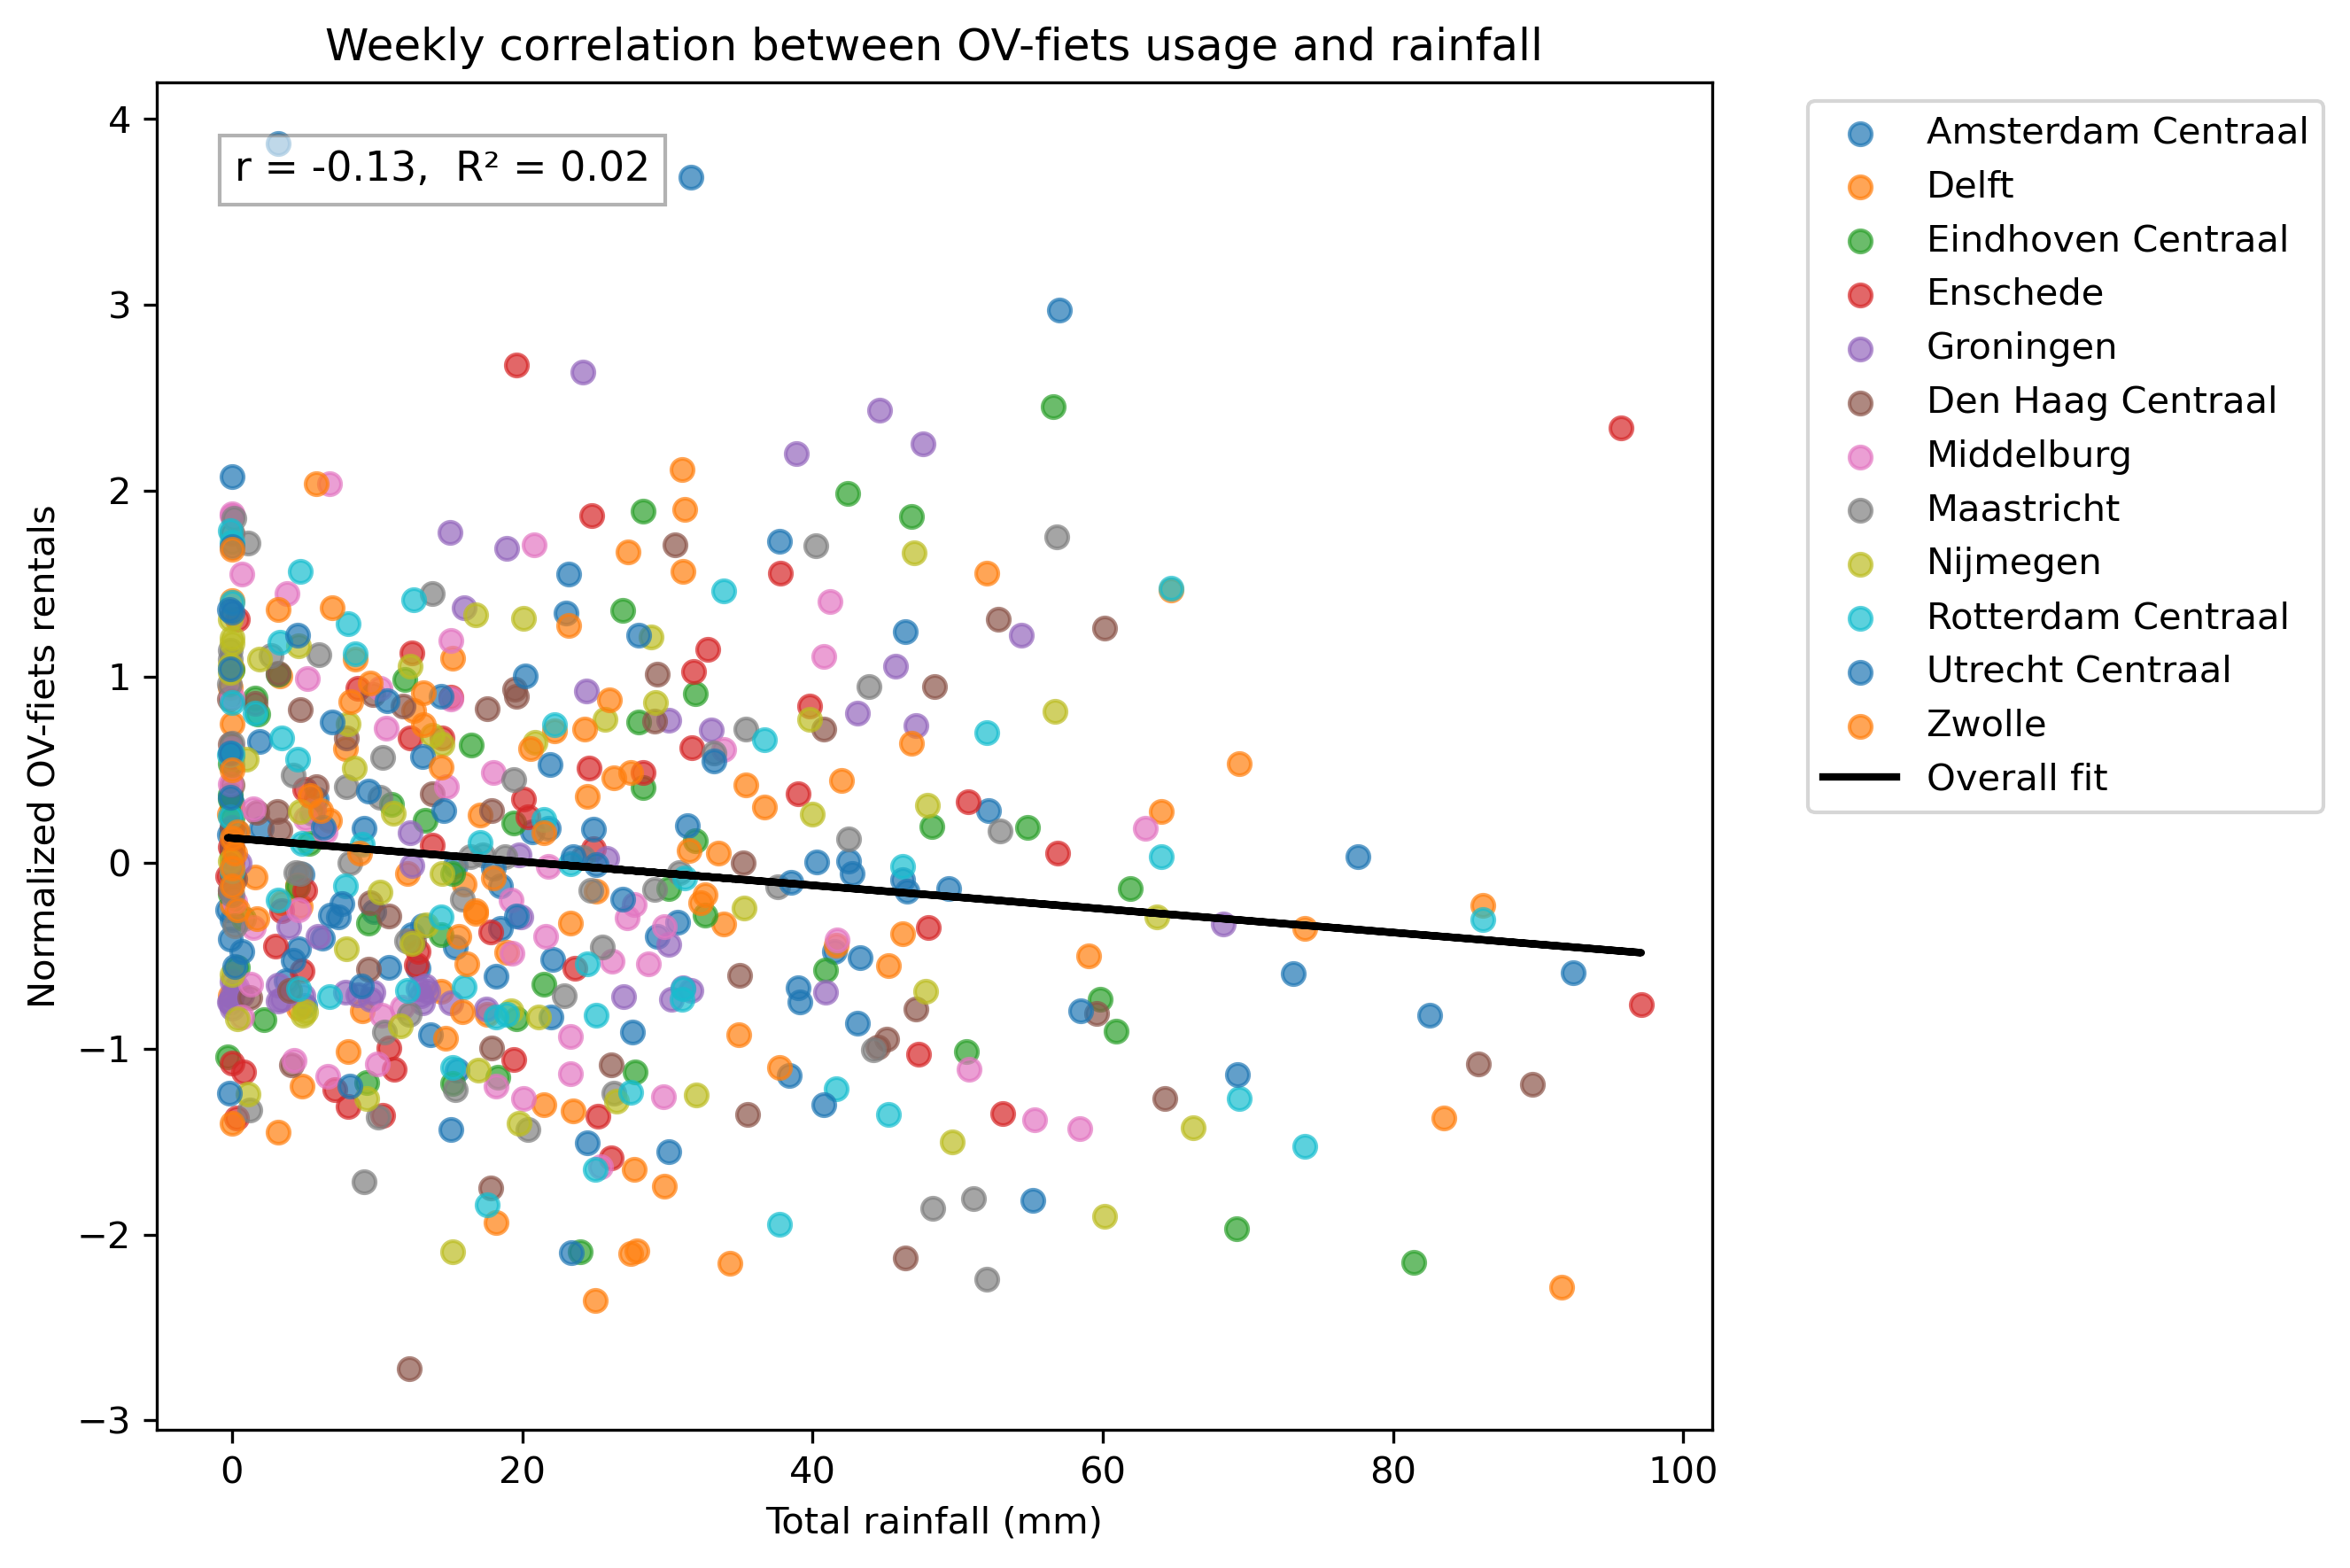

In [25]:
# Plot  rainfall correlation for multiple stations with linear fit

plt.figure(figsize=(9,6),dpi=300)

# Scatter points per station
for st in merged["station_full"].unique():
    subset = merged[merged["station_full"] == st]
    plt.scatter(
        subset["rainfall"],
        subset["norm_rentals"],
        label=st,
        alpha=0.7
    )

# Overall linear fit
x = merged["rainfall"]
y = merged["norm_rentals"]
m, b = np.polyfit(x, y, 1)
plt.plot(x, m*x + b, color="black", linewidth=2, label="Overall fit")

# Compute overall correlation
r = np.corrcoef(x, y)[0, 1]
r_squared = r**2

# Add correlation text
plt.text(
    0.05, 0.95,
    f"r = {r:.2f},  R² = {r_squared:.2f}",
    transform=plt.gca().transAxes,
    fontsize=11,
    verticalalignment='top',
    bbox=dict(facecolor='white', alpha=0.6, edgecolor='gray')
)

# Labels and title
plt.xlabel("Total rainfall (mm)")
plt.ylabel("Normalized OV-fiets rentals")
plt.title("Weekly correlation between OV-fiets usage and rainfall")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


In [26]:
# # Plot one station


# weekly_avg_ov_fiets_delft = weekly_avg_ov_fiets[weekly_avg_ov_fiets['station'] == "['DT']"]

# x = weekly_avg_knmi[0:26] / 10
# y = weekly_avg_ov_fiets_delft["total_rentals_station"]


# plt.figure()
# plt.scatter(x,y)
# plt.ylabel('Number of bikes')
# plt.xlabel('Temperature')
# plt.xlim(0,20)
# # plt.ylim(0,350)
# plt.title('Correlationplot ov-bikes')
